In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import csv
from sklearn.linear_model import Ridge


In [310]:
df_hospital=pd.read_csv("processed_data/dublinbikes_james_hospital.csv")
df_portobello=pd.read_csv("processed_data/dublinbikes_portobello.csv")

Lets get some basic features like day of week, weekend, time

In [311]:
def get_basic_features(df:pd.DataFrame):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["DAY OF WEEK"]=df["TIME"].dt.dayofweek-1
    df["HOUR"]=df["TIME"].dt.strftime("%H").astype(int)
    df["MINUTE"]=df["TIME"].dt.strftime("%M").astype(int)

    
    return df

In [312]:
df_hospital_map={}
df_portobello_map={}

In [313]:
df_hospital = get_basic_features(df_hospital)
df_portobello = get_basic_features(df_portobello)

In [314]:

df_hospital[500:520]

,TIME,BIKE STANDS,AVAILABLE BIKES,DAY OF WEEK,HOUR,MINUTE
500,2020-01-29 17:40:02,40,12,1,17,40
501,2020-01-29 17:45:02,40,10,1,17,45
502,2020-01-29 17:50:02,40,12,1,17,50
503,2020-01-29 17:55:02,40,12,1,17,55
504,2020-01-29 18:00:02,40,13,1,18,0
505,2020-01-29 18:05:02,40,13,1,18,5
506,2020-01-29 18:10:02,40,15,1,18,10
507,2020-01-29 18:15:02,40,15,1,18,15
508,2020-01-29 18:20:02,40,14,1,18,20
509,2020-01-29 18:25:02,40,14,1,18,25


Lets add some more complex features using weekly, daily and short-term seasonality trends in the data

For short term trends lets use intervals of 15 min, and get the last three intervals

In [315]:
def get_trend_features(df:pd.DataFrame):
    df["CURRENT AVAILABILITY"] = df["AVAILABLE BIKES"]
    df["5MIN AGO"] = df["AVAILABLE BIKES"].shift(1)
    df["10MIN AGO"] = df["AVAILABLE BIKES"].shift(2)
    df["15MIN AGO"] = df["AVAILABLE BIKES"].shift(3)
    df["20MIN AGO"] = df["AVAILABLE BIKES"].shift(4)
    df["25MIN AGO"] = df["AVAILABLE BIKES"].shift(5)
    df["30MIN AGO"] = df["AVAILABLE BIKES"].shift(6)
    df["40MIN AGO"] = df["AVAILABLE BIKES"].shift(8)
    df["50MIN AGO"] = df["AVAILABLE BIKES"].shift(10)
    df["60MIN AGO"] = df["AVAILABLE BIKES"].shift(12)
    df["70MIN AGO"] = df["AVAILABLE BIKES"].shift(14)
    df["80MIN AGO"] = df["AVAILABLE BIKES"].shift(16)
    df["1DAY AGO"] = df["AVAILABLE BIKES"].shift(12*24)
    df["2DAYS AGO"] = df["AVAILABLE BIKES"].shift(12*24*2)
    df["3DAYS AGO"] = df["AVAILABLE BIKES"].shift(12*24*3)
    df["1WEEK AGO"] = df["AVAILABLE BIKES"].shift(12*24*7)
    df.dropna(inplace=True)
    return df

In [316]:
def shift_target_variable(df:pd.DataFrame, prediction_time : int):
    df=df.copy(deep=True)
    prediction_int = np.trunc(prediction_time/5) -1 
    prediction_int=prediction_int.astype(int)
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"].shift(prediction_int)
    df.dropna(inplace=True)
    return df

In [317]:
def normalize_features(df:pd.DataFrame):
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"]/df["BIKE STANDS"]
    df["DAY OF WEEK"] = df["DAY OF WEEK"] / 6
    df["HOUR"] = df["HOUR"] / max(df["HOUR"])
    df["MINUTE"] = df["MINUTE"] / max(df["MINUTE"])
    return df

In [318]:
df_hospital=normalize_features(df_hospital)
df_hospital=get_trend_features(df_hospital)

df_portobello=normalize_features(df_portobello)
df_portobello=get_trend_features(df_portobello)


df_hospital.set_index("TIME",inplace=True,drop=True)
df_portobello.set_index("TIME",inplace=True,drop=True)


In [319]:

df_hospital_map["10MIN"]=shift_target_variable(df_hospital, prediction_time = 10)
df_portobello_map["10MIN"]=shift_target_variable(df_portobello, prediction_time = 10)

df_hospital_map["30MIN"]=shift_target_variable(df_hospital, prediction_time = 30)
df_portobello_map["30MIN"]=shift_target_variable(df_portobello, prediction_time = 30)

df_hospital_map["60MIN"]=shift_target_variable(df_hospital, prediction_time = 60)
df_portobello_map["60MIN"]=shift_target_variable(df_portobello, prediction_time =  60)



In [320]:
df_hospital["10MIN AHEAD"] = df_hospital_map["10MIN"]["AVAILABLE BIKES"]
df_hospital[500:520]

,BIKE STANDS,AVAILABLE BIKES,DAY OF WEEK,HOUR,MINUTE,CURRENT AVAILABILITY,5MIN AGO,10MIN AGO,15MIN AGO,20MIN AGO,...,40MIN AGO,50MIN AGO,60MIN AGO,70MIN AGO,80MIN AGO,1DAY AGO,2DAYS AGO,3DAYS AGO,1WEEK AGO,10MIN AHEAD
TIME,,,,,,,,,,,,,,,,,,,,,
2020-02-05 17:40:02,40,0.400,0.166667,0.739130,0.701754,0.400,0.400,0.375,0.425,0.425,...,0.400,0.400,0.400,0.475,0.500,0.425,0.200,0.350,0.300,0.400
2020-02-05 17:45:02,40,0.400,0.166667,0.739130,0.789474,0.400,0.400,0.400,0.375,0.425,...,0.375,0.400,0.400,0.475,0.500,0.375,0.175,0.325,0.250,0.400
2020-02-05 17:50:02,40,0.425,0.166667,0.739130,0.877193,0.425,0.400,0.400,0.400,0.375,...,0.400,0.400,0.400,0.400,0.475,0.375,0.200,0.325,0.300,0.400
2020-02-05 17:55:02,40,0.425,0.166667,0.739130,0.964912,0.425,0.425,0.400,0.400,0.400,...,0.400,0.375,0.400,0.400,0.475,0.350,0.225,0.325,0.300,0.425
2020-02-05 18:00:02,40,0.450,0.166667,0.782609,0.000000,0.450,0.425,0.425,0.400,0.400,...,0.425,0.400,0.400,0.400,0.400,0.350,0.250,0.325,0.325,0.425
2020-02-05 18:05:02,40,0.450,0.166667,0.782609,0.087719,0.450,0.450,0.425,0.425,0.400,...,0.425,0.400,0.375,0.400,0.400,0.325,0.250,0.325,0.325,0.450
2020-02-05 18:10:02,40,0.450,0.166667,0.782609,0.175439,0.450,0.450,0.450,0.425,0.425,...,0.375,0.425,0.400,0.400,0.400,0.375,0.225,0.325,0.375,0.450
2020-02-05 18:15:02,40,0.375,0.166667,0.782609,0.263158,0.375,0.450,0.450,0.450,0.425,...,0.400,0.425,0.400,0.375,0.400,0.350,0.225,0.325,0.375,0.450
2020-02-05 18:20:02,40,0.350,0.166667,0.782609,0.350877,0.350,0.375,0.450,0.450,0.450,...,0.400,0.375,0.425,0.400,0.400,0.375,0.175,0.325,0.350,0.375


In [321]:
def get_X_and_y(df:map):
    X={}
    y={}
    y["10MIN"]=df["10MIN"]["AVAILABLE BIKES"]
    X["10MIN"] = df["10MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["30MIN"]=df["30MIN"]["AVAILABLE BIKES"]
    X["30MIN"] = df["30MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["60MIN"]=df["60MIN"]["AVAILABLE BIKES"]
    X["60MIN"] = df["60MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    return X,y

In [322]:
X_portobello,y_portobello=get_X_and_y(df_portobello_map)
X_hospital,y_hospital=get_X_and_y(df_hospital_map)


In [323]:
y_portobello["60MIN"][500:510]

TIME
2020-02-05 18:35:02    0.266667
2020-02-05 18:40:02    0.100000
2020-02-05 18:45:02    0.200000
2020-02-05 18:50:02    0.233333
2020-02-05 18:55:02    0.333333
2020-02-05 19:00:02    0.300000
2020-02-05 19:05:02    0.300000
2020-02-05 19:10:02    0.300000
2020-02-05 19:15:02    0.300000
2020-02-05 19:20:02    0.366667
Name: AVAILABLE BIKES, dtype: float64

In [324]:
ridge_model_portobello = {}
ridge_model_hospital = {}

for key in X_portobello.keys():
    ridge_model_portobello[key]=Ridge().fit(X_portobello[key],y_portobello[key])
    ridge_model_hospital[key]=Ridge().fit(X_hospital[key],y_hospital[key])



In [325]:
hospital_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_hospital["10MIN"].coef_,
"30 Min Prediciton":ridge_model_hospital["30MIN"].coef_,
"60 Min Prediciton":ridge_model_hospital["60MIN"].coef_
})

portobello_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_portobello["10MIN"].coef_,
"30 Min Prediciton":ridge_model_portobello["30MIN"].coef_,
"60 Min Prediciton":ridge_model_portobello["60MIN"].coef_
})

hospital_features_df.set_index("Feature Name",inplace=True)
portobello_features_df.set_index("Feature Name",inplace=True)


hospital_features_df

,10 Min Prediciton,30 Min Prediciton,60 Min Prediciton
Feature Name,,,
DAY OF WEEK,0.000007,-4.393751e-06,-0.000024
HOUR,-0.000020,5.442007e-06,0.000062
MINUTE,-0.000002,-3.283662e-05,0.000441
CURRENT AVAILABILITY,0.088043,-1.688410e-03,-0.002423
5MIN AGO,0.822890,3.557402e-03,0.007181
10MIN AGO,0.096160,-4.506429e-03,-0.009486
15MIN AGO,-0.004494,-4.487721e-03,0.009805
20MIN AGO,-0.004362,9.610422e-02,-0.002405
25MIN AGO,0.003557,8.222631e-01,-0.007640


Text(0.5, 1.0, 'St James Hospital Bike Station')

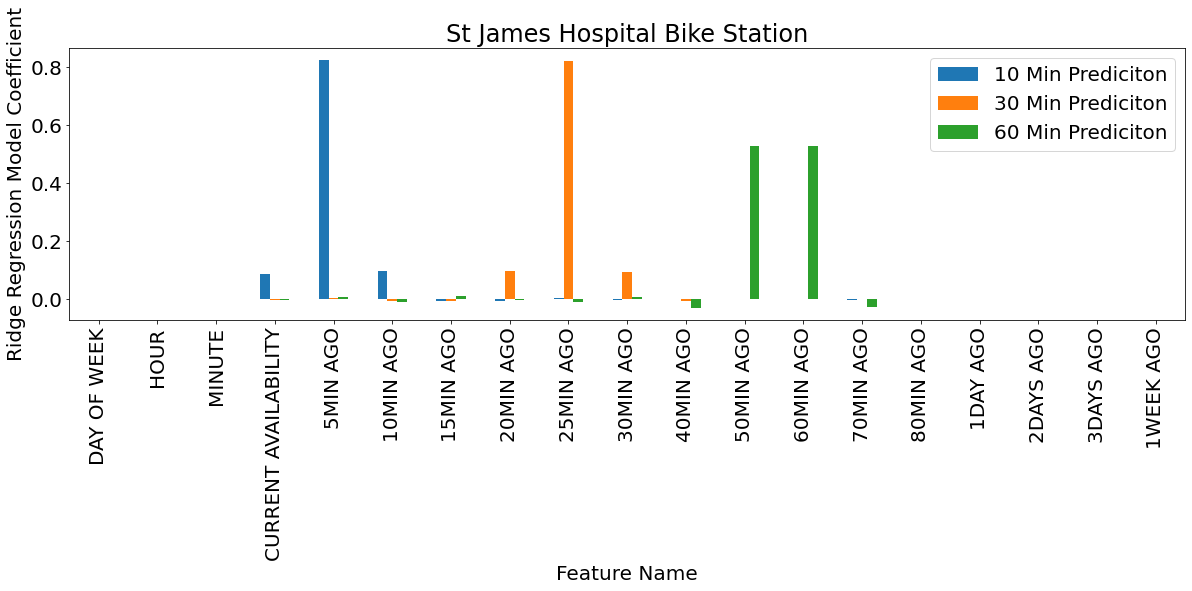

In [326]:
plt.rc('font',size=20)
hospital_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("St James Hospital Bike Station")

Text(0.5, 1.0, 'Portobello Bike Station')

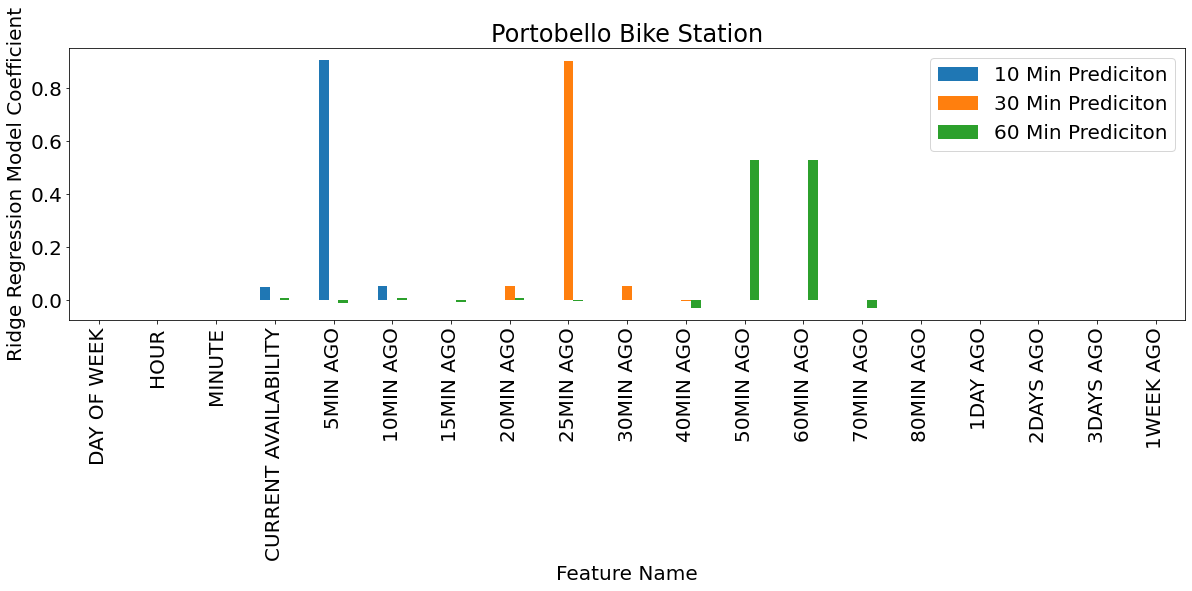

In [327]:
plt.rc('font',size=20)
portobello_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("Portobello Bike Station")